In [1]:
import keras
import random
from keras import ops
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#drop path package
class DropPath(keras.layers.Layer):
    """
    DropPath layer implementation for Keras 3
    Randomly drops samples during training with probability `rate`
    """
    def __init__(self, rate=0.5, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        self.seed = seed

        self.rng = np.random.default_rng(seed)
        self.drop_mask = None
        self.last_batch_size = None

    def build(self, input_shape):

        self.drop_mask = ops.zeros((1,), dtype="float32")
        super().build(input_shape)

    def call(self, x, training=None):
        if self.rate == 0.0 or not training:
            return x


        batch_size = x.shape[0] if x.shape[0] is not None else ops.shape(x)[0]


        if batch_size != self.last_batch_size:

            drop_shape = [batch_size] + [1] * (len(x.shape) - 1)


            rand_mask = self.rng.uniform(size=drop_shape)
            self.drop_mask = ops.cast(ops.array(rand_mask > self.rate), x.dtype)
            self.last_batch_size = batch_size

        x = x / (1.0 - self.rate)
        return x * self.drop_mask

    def get_config(self):
        config = super().get_config()
        config.update({"rate": self.rate, "seed": self.seed})
        return config


In [3]:
class SqueezeAndExcitation(layers.Layer):
    """Squeeze and excitation block.

    Args:
        output_dim: output features dimension, if `None` use same dim as input.
        expansion: expansion ratio.
    """

    def __init__(self, output_dim=None, expansion=0.25, **kwargs):
        super().__init__(**kwargs)
        self.expansion = expansion
        self.output_dim = output_dim

    def build(self, input_shape):
        inp = input_shape[-1]
        self.output_dim = self.output_dim or inp
        self.avg_pool = layers.GlobalAvgPool2D(keepdims=True, name="avg_pool")
        self.fc = [
            layers.Dense(int(inp * self.expansion), use_bias=False, name="fc_0"),
            layers.Activation("gelu", name="fc_1"),
            layers.Dense(self.output_dim, use_bias=False, name="fc_2"),
            layers.Activation("sigmoid", name="fc_3"),
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.avg_pool(inputs)
        for layer in self.fc:
            x = layer(x)
        return x * inputs


class ReduceSize(layers.Layer):
    """Down-sampling block.

    Args:
        keepdims: if False spatial dim is reduced and channel dim is increased
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        dim_out = embed_dim if self.keepdims else 2 * embed_dim
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv_0"
            ),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv_3",
            ),
        ]
        self.reduction = layers.Conv2D(
            dim_out,
            kernel_size=3,
            strides=2,
            padding="valid",
            use_bias=False,
            name="reduction",
        )
        self.norm1 = layers.LayerNormalization(
            -1, 1e-05, name="norm1"
        )  # eps like PyTorch
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")

    def call(self, inputs, **kwargs):
        x = self.norm1(inputs)
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        x = self.pad2(x)
        x = self.reduction(x)
        x = self.norm2(x)
        return x


class MLP(layers.Layer):
    """Multi-Layer Perceptron (MLP) block.

    Args:
        hidden_features: hidden features dimension.
        out_features: output features dimension.
        activation: activation function.
        dropout: dropout rate.
    """

    def __init__(
        self,
        hidden_features=None,
        out_features=None,
        activation="gelu",
        dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.activation = activation
        self.dropout = dropout

    def build(self, input_shape):
        self.in_features = input_shape[-1]
        self.hidden_features = self.hidden_features or self.in_features
        self.out_features = self.out_features or self.in_features
        self.fc1 = layers.Dense(self.hidden_features, name="fc1")
        self.act = layers.Activation(self.activation, name="act")
        self.fc2 = layers.Dense(self.out_features, name="fc2")
        self.drop1 = layers.Dropout(self.dropout, name="drop1")
        self.drop2 = layers.Dropout(self.dropout, name="drop2")

    def call(self, inputs, **kwargs):
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

In [4]:
class PatchEmbed(layers.Layer):
    """Patch embedding block.

    Args:
        embed_dim: feature size dimension.
    """

    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pad = layers.ZeroPadding2D(1, name="pad")
        self.proj = layers.Conv2D(self.embed_dim, 3, 2, name="proj")
        self.conv_down = ReduceSize(keepdims=True, name="conv_down")

    def call(self, inputs, **kwargs):
        x = self.pad(inputs)
        x = self.proj(x)
        x = self.conv_down(x)
        return x


In [5]:
class FeatureExtraction(layers.Layer):
    """Feature extraction block.

    Args:
        keepdims: bool argument for maintaining the resolution.
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(3, 1, use_bias=False, name="conv_0"),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(embed_dim, 1, 1, use_bias=False, name="conv_3"),
        ]
        if not self.keepdims:
            self.pool = layers.MaxPool2D(3, 2, name="pool")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        if not self.keepdims:
            x = self.pool(self.pad2(x))
        return x


class GlobalQueryGenerator(layers.Layer):
    """Global query generator.

    Args:
        keepdims: to keep the dimension of FeatureExtraction layer.
        For instance, repeating log(56/7) = 3 blocks, with input
        window dimension 56 and output window dimension 7 at down-sampling
        ratio 2. Please check Fig.5 of GC ViT paper for details.
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        self.to_q_global = [
            FeatureExtraction(keepdims, name=f"to_q_global_{i}")
            for i, keepdims in enumerate(self.keepdims)
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.to_q_global:
            x = layer(x)
        return x

In [6]:
class WindowAttention(layers.Layer):
    """Local window attention.

    This implementation was proposed by
    [Liu et al., 2021](https://arxiv.org/abs/2103.14030) in SwinTransformer.

    Args:
        window_size: window size.
        num_heads: number of attention head.
        global_query: if the input contains global_query
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        attention_dropout: attention dropout rate.
        projection_dropout: output dropout rate.
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        projection_dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        window_size = (window_size, window_size)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.projection_dropout = projection_dropout

    def build(self, input_shape):
        embed_dim = input_shape[0][-1]
        head_dim = embed_dim // self.num_heads
        self.scale = self.qk_scale or head_dim**-0.5
        self.qkv_size = 3 - int(self.global_query)
        self.qkv = layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv"
        )
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            ],
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        )
        self.attn_drop = layers.Dropout(self.attention_dropout, name="attn_drop")
        self.proj = layers.Dense(embed_dim, name="proj")
        self.proj_drop = layers.Dropout(self.projection_dropout, name="proj_drop")
        self.softmax = layers.Activation("softmax", name="softmax")
        super().build(input_shape)

    def get_relative_position_index(self):
        coords_h = ops.arange(self.window_size[0])
        coords_w = ops.arange(self.window_size[1])
        coords = ops.stack(ops.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = ops.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = ops.transpose(relative_coords, axes=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
            B = ops.shape(q_global)[0]  # B, N, C
        else:
            inputs = inputs[0]
        B_, N, C = ops.shape(inputs)  # B*num_window, num_tokens, channels
        qkv = self.qkv(inputs)
        qkv = ops.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads]
        )
        qkv = ops.transpose(qkv, [2, 0, 3, 1, 4])
        if self.global_query:
            k, v = ops.split(
                qkv, indices_or_sections=2, axis=0
            )  # for unknown shame num=None will throw error
            q_global = ops.repeat(
                q_global, repeats=B_ // B, axis=0
            )  # num_windows = B_//B => q_global same for all windows in a img
            q = ops.reshape(q_global, [B_, N, self.num_heads, C // self.num_heads])
            q = ops.transpose(q, axes=[0, 2, 1, 3])
        else:
            q, k, v = ops.split(qkv, indices_or_sections=3, axis=0)
            q = ops.squeeze(q, axis=0)

        k = ops.squeeze(k, axis=0)
        v = ops.squeeze(v, axis=0)

        q = q * self.scale
        attn = q @ ops.transpose(k, axes=[0, 1, 3, 2])
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            ops.reshape(self.get_relative_position_index(), [-1]),
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            [
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = ops.transpose(relative_position_bias, axes=[2, 0, 1])
        attn = attn + relative_position_bias[None,]
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = ops.transpose((attn @ v), axes=[0, 2, 1, 3])
        x = ops.reshape(x, [B_, N, C])
        x = self.proj_drop(self.proj(x))
        return x


In [7]:
class Block(layers.Layer):
    """GCViT block.

    Args:
        window_size: window size.
        num_heads: number of attention head.
        global_query: apply global window attention
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        drop: dropout rate.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        activation: activation function.
        layer_scale: layer scaling coefficient.
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        activation="gelu",
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.activation = activation
        self.layer_scale = layer_scale

    def build(self, input_shape):
        B, H, W, C = input_shape[0]
        self.norm1 = layers.LayerNormalization(-1, 1e-05, name="norm1")
        self.attn = WindowAttention(
            window_size=self.window_size,
            num_heads=self.num_heads,
            global_query=self.global_query,
            qkv_bias=self.qkv_bias,
            qk_scale=self.qk_scale,
            attention_dropout=self.attention_dropout,
            projection_dropout=self.dropout,
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)
        self.drop_path2 = DropPath(self.path_drop)
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")
        self.mlp = MLP(
            hidden_features=int(C * self.mlp_ratio),
            dropout=self.dropout,
            activation=self.activation,
            name="mlp",
        )
        if self.layer_scale is not None:
            self.gamma1 = self.add_weight(
                name="gamma1",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
            self.gamma2 = self.add_weight(
                name="gamma2",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]
        B, H, W, C = ops.shape(inputs)
        x = self.norm1(inputs)
        # create windows and concat them in batch axis
        x = self.window_partition(x, self.window_size)  # (B_, win_h, win_w, C)
        # flatten patch
        x = ops.reshape(x, [-1, self.window_size * self.window_size, C])
        # attention
        if self.global_query:
            x = self.attn([x, q_global])
        else:
            x = self.attn([x])
        # reverse window partition
        x = self.window_reverse(x, self.window_size, H, W, C)
        # FFN
        x = inputs + self.drop_path1(x * self.gamma1)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))
        return x

    def window_partition(self, x, window_size):
        """
        Args:
            x: (B, H, W, C)
            window_size: window size
        Returns:
            local window features (num_windows*B, window_size, window_size, C)
        """
        B, H, W, C = ops.shape(x)
        x = ops.reshape(
            x,
            [
                -1,
                H // window_size,
                window_size,
                W // window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        windows = ops.reshape(x, [-1, window_size, window_size, C])
        return windows

    def window_reverse(self, windows, window_size, H, W, C):
        """
        Args:
            windows: local window features (num_windows*B, window_size, window_size, C)
            window_size: Window size
            H: Height of image
            W: Width of image
            C: Channel of image
        Returns:
            x: (B, H, W, C)
        """
        x = ops.reshape(
            windows,
            [
                -1,
                H // window_size,
                W // window_size,
                window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        x = ops.reshape(x, [-1, H, W, C])
        return x

In [8]:
class Level(layers.Layer):
    """GCViT level.

    Args:
        depth: number of layers in each stage.
        num_heads: number of heads in each stage.
        window_size: window size in each stage.
        keepdims: dims to keep in FeatureExtraction.
        downsample: bool argument for down-sampling.
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        drop: dropout rate.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        layer_scale: layer scaling coefficient.
    """

    def __init__(
        self,
        depth,
        num_heads,
        window_size,
        keepdims,
        downsample=True,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.keepdims = keepdims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale

    def build(self, input_shape):
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        self.blocks = [
            Block(
                window_size=self.window_size,
                num_heads=self.num_heads,
                global_query=bool(i % 2),
                mlp_ratio=self.mlp_ratio,
                qkv_bias=self.qkv_bias,
                qk_scale=self.qk_scale,
                dropout=self.dropout,
                attention_dropout=self.attention_dropout,
                path_drop=path_drop[i],
                layer_scale=self.layer_scale,
                name=f"blocks_{i}",
            )
            for i in range(self.depth)
        ]
        self.down = ReduceSize(keepdims=False, name="downsample")
        self.q_global_gen = GlobalQueryGenerator(self.keepdims, name="q_global_gen")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        q_global = self.q_global_gen(x)  # shape: (B, win_size, win_size, C)
        for i, blk in enumerate(self.blocks):
            if i % 2:
                x = blk([x, q_global])  # shape: (B, H, W, C)
            else:
                x = blk([x])  # shape: (B, H, W, C)
        if self.downsample:
            x = self.down(x)  # shape: (B, H//2, W//2, 2*C)
        return x

In [9]:
class GCViT(keras.Model):
    """GCViT model.

    Args:
        window_size: window size in each stage.
        embed_dim: feature size dimension.
        depths: number of layers in each stage.
        num_heads: number of heads in each stage.
        drop_rate: dropout rate.
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        layer_scale: layer scaling coefficient.
        num_classes: number of classes.
        head_activation: activation function for head.
    """

    def __init__(
        self,
        window_size,
        embed_dim,
        depths,
        num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_activation="softmax",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.drop_rate = drop_rate
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale
        self.num_classes = num_classes
        self.head_activation = head_activation

        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        self.pos_drop = layers.Dropout(drop_rate, name="pos_drop")
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        keepdims = [(0, 0, 0), (0, 0), (1,), (1,)]
        self.levels = []
        for i in range(len(depths)):
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            level = Level(
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size[i],
                keepdims=keepdims[i],
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                dropout=drop_rate,
                attention_dropout=attention_dropout,
                path_drop=path_drop,
                layer_scale=layer_scale,
                name=f"levels_{i}",
            )
            self.levels.append(level)
        self.norm = layers.LayerNormalization(axis=-1, epsilon=1e-05, name="norm")
        self.pool = layers.GlobalAvgPool2D(name="pool")
        self.head = layers.Dense(num_classes, name="head", activation=head_activation)

    def build(self, input_shape):
        super().build(input_shape)
        self.built = True

    def call(self, inputs, **kwargs):
        x = self.patch_embed(inputs)  # shape: (B, H, W, C)
        x = self.pos_drop(x)
        for level in self.levels:
            x = level(x)  # shape: (B, H_, W_, C_)
        x = self.norm(x)
        x = self.pool(x)  # shape: (B, C__)
        x = self.head(x)
        return x

    def build_graph(self, input_shape=(224, 224, 3)):
        """
        ref: https://www.kaggle.com/code/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam
        """
        x = keras.Input(shape=input_shape)
        return keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        return self.build_graph(input_shape).summary()

In [10]:
from google.colab import files
uploaded = files.upload()

Saving gcvitxxtiny.keras to gcvitxxtiny.keras


In [11]:
# Model Configs
config = {
    "window_size": (7, 7, 14, 7),
    "embed_dim": 64,
    "depths": (2, 2, 6, 2),
    "num_heads": (2, 4, 8, 16),
    "mlp_ratio": 3.0,
    "path_drop": 0.2,
}
# Build Model
model = GCViT(**config)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Load Weights
ckpt_path = r"/content/gcvitxxtiny.keras"  # <- modified to use local file
model.load_weights(ckpt_path)

# Summary
model.summary((224, 224, 3))

Model: "gc_vi_t"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed (PatchEmbed)        │ (None, 56, 56, 64)     │        45,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pos_drop (Dropout)              │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_0 (Level)                │ (None, 28, 28, 128)    │       180,964 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_1 (Level)                │ (None, 14, 14, 256)    │       688,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_2 (Level)                │ (None, 7, 7, 512)      │     5,170,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_3 (Level)                │ (None, 7, 7, 512)      │     5,395,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (LayerNormalization)       │ (None, 7, 7, 512)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool (GlobalAveragePooling2D)   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 1000)           │       513,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,995,428 (45.76 MB)

 Trainable params: 11,995,428 (45.76 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model

ckpt_link = (
    "https://github.com/awsaf49/gcvit-tf/releases/download/v1.1.6/gcvitxxtiny.keras"
)
IMAGE_SIZE = (224, 224)

# Hyper Params
BATCH_SIZE = 32
EPOCHS = 5

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = 255 * np.array([0.485, 0.456, 0.406], dtype="float32")  # imagenet mean
STD = 255 * np.array([0.229, 0.224, 0.225], dtype="float32")  # imagenet std
AUTO = tf.data.AUTOTUNE


def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

# Re-Build Model
model = GCViT(**config, num_classes=104)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Load Weights
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
model.load_weights(ckpt_path, skip_mismatch=True)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.L0U835_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
48767519/48767519 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=head, built=True>:

Layer 'head' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=head, built=True>]
  warnings.warn(msg)


In [13]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1
)

Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 171s 826ms/step - accuracy: 0.6456 - loss: 1.2003 - val_accuracy: 0.7847 - val_loss: 0.5572
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.8904 - loss: 0.2855 - val_accuracy: 0.8147 - val_loss: 0.5401
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 338ms/step - accuracy: 0.8875 - loss: 0.3043 - val_accuracy: 0.8311 - val_loss: 0.5304
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.8775 - loss: 0.3391 - val_accuracy: 0.8556 - val_loss: 0.4439
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.9106 - loss: 0.2358 - val_accuracy: 0.8828 - val_loss: 0.3605


In [14]:
print("Accuracy of the model:", history.history["accuracy"][-1])
print("Validation Accuracy of the model:", history.history["val_accuracy"][-1])

Accuracy of the model: 0.9321828484535217
Validation Accuracy of the model: 0.8828337788581848


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 903ms/step


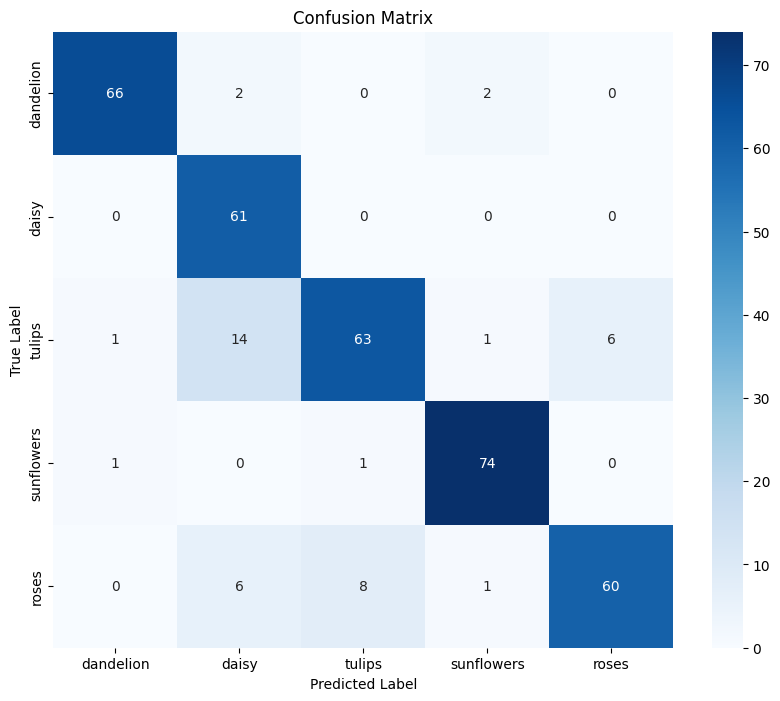

In [15]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for images, labels in val_dataset:
  y_true.extend(labels.numpy())


conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Found 324 correctly classified images.


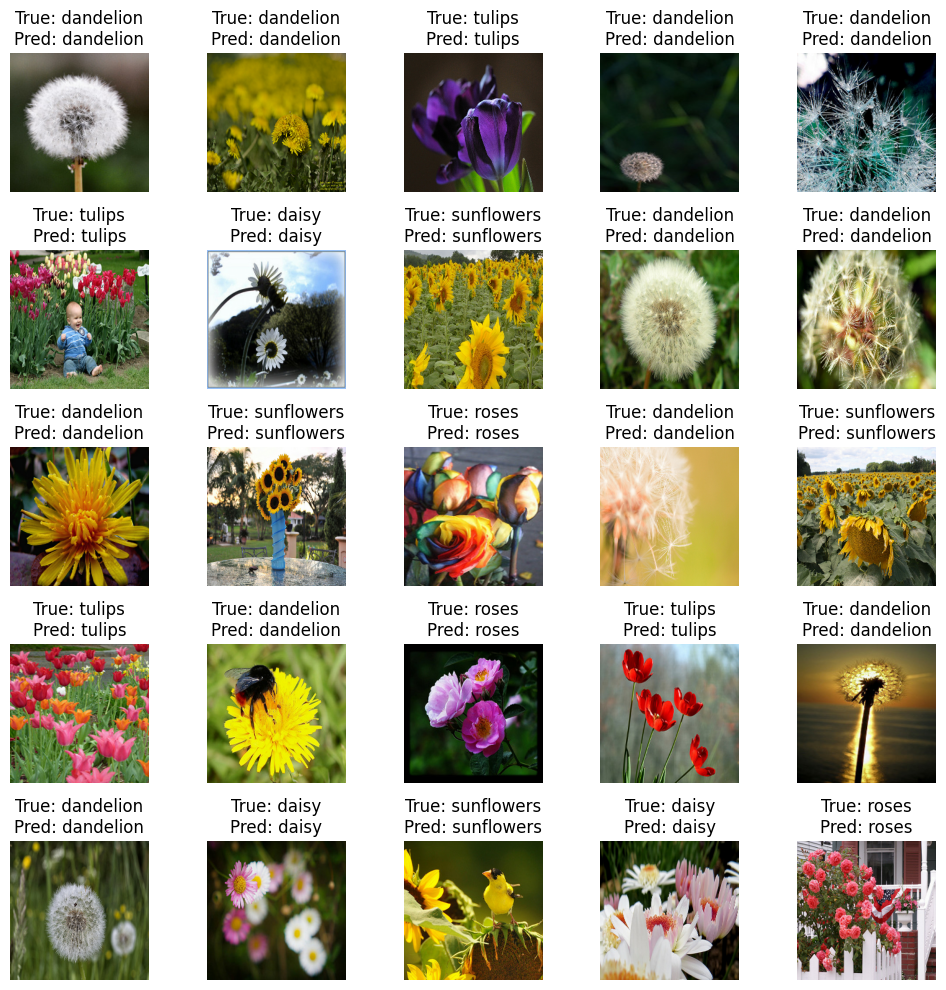

In [16]:

correctly_classified_images = []
correctly_classified_labels = []
predicted_labels = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = labels.numpy()

    for i in range(len(images)):
        if predicted_classes[i] == true_labels[i]:
            correctly_classified_images.append(images[i].numpy())
            correctly_classified_labels.append(CLASSES[true_labels[i]])
            predicted_labels.append(CLASSES[predicted_classes[i]])

print(f"Found {len(correctly_classified_images)} correctly classified images.")


plt.figure(figsize=(10, 10))
for i in range(min(25, len(correctly_classified_images))):
    ax = plt.subplot(5, 5, i + 1)

    img = correctly_classified_images[i] * STD + MEAN
    img = np.clip(img, 0, 255).astype("uint8")
    plt.imshow(img)
    plt.title(f"True: {correctly_classified_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [18]:

from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))




Classification Report:
              precision    recall  f1-score   support

   dandelion       0.97      0.94      0.96        70
       daisy       0.73      1.00      0.85        61
      tulips       0.88      0.74      0.80        85
  sunflowers       0.95      0.97      0.96        76
       roses       0.91      0.80      0.85        75

    accuracy                           0.88       367
   macro avg       0.89      0.89      0.88       367
weighted avg       0.89      0.88      0.88       367



In [19]:
# prompt: make a table of all evalutation metrics

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate individual metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro') # Use macro average for multi-class
recall = recall_score(y_true, y_pred_classes, average='macro')     # Use macro average for multi-class
f1 = f1_score(y_true, y_pred_classes, average='macro')           # Use macro average for multi-class


# Create a dictionary for the metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
    'Score': [accuracy, precision, recall, f1]
}

# Create a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Print the table
print("\nEvaluation Metrics:")
print(metrics_df.to_markdown(index=False))



Evaluation Metrics:
| Metric            |    Score |
|:------------------|---------:|
| Accuracy          | 0.882834 |
| Precision (Macro) | 0.887667 |
| Recall (Macro)    | 0.891544 |
| F1-Score (Macro)  | 0.883679 |


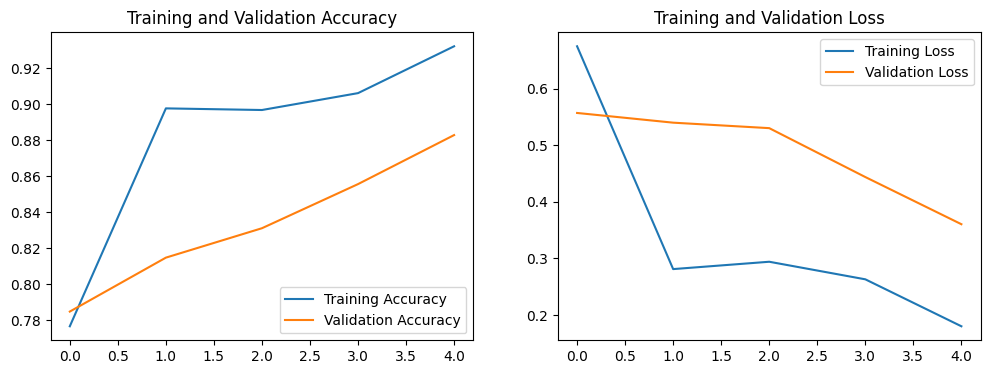

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Found 43 misclassified images.


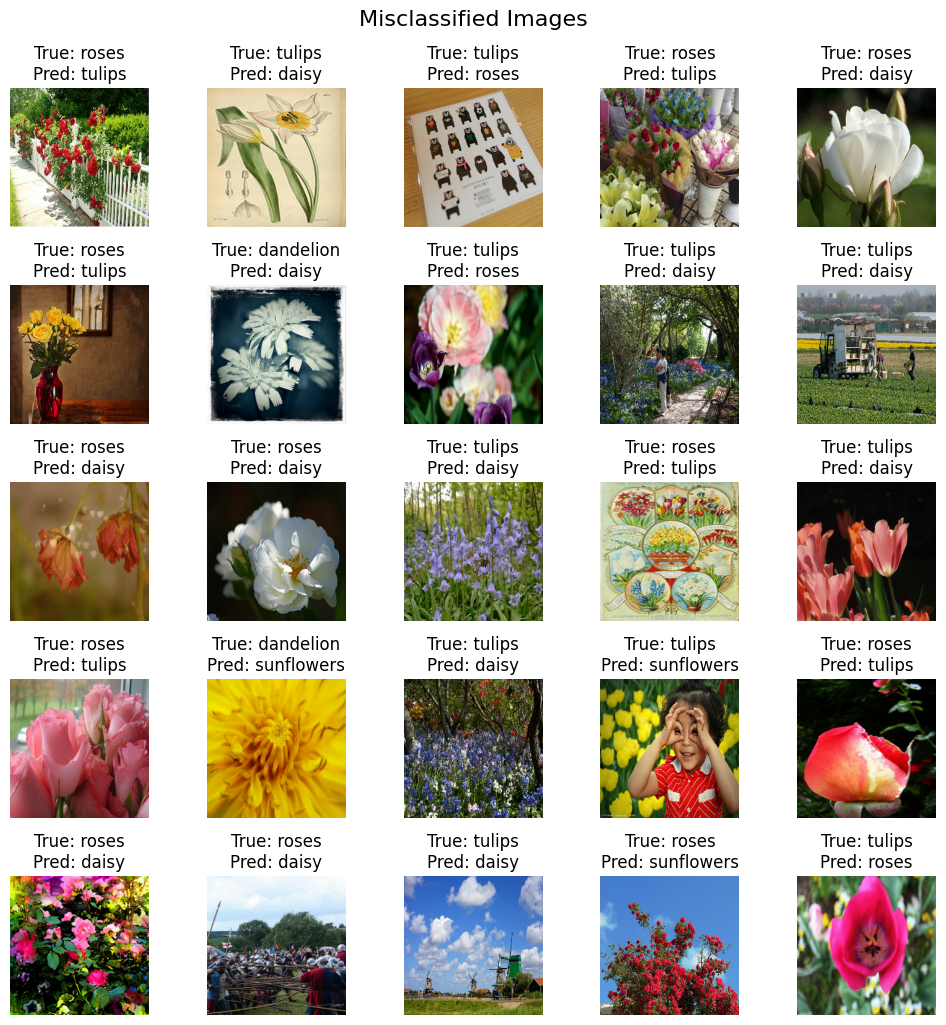

In [21]:

def plot_history(history):
    """Plots training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the training history
plot_history(history)

# Function to display misclassified images
def plot_misclassified_images(model, dataset, classes, num_images=25):
    """Displays a sample of misclassified images with true and predicted labels."""
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = labels.numpy()

        for i in range(len(images)):
            if predicted_classes[i] != true_classes[i]:
                misclassified_images.append(images[i].numpy())
                true_labels.append(classes[true_classes[i]])
                predicted_labels.append(classes[predicted_classes[i]])

    print(f"\nFound {len(misclassified_images)} misclassified images.")

    if len(misclassified_images) > 0:
        plt.figure(figsize=(10, 10))
        for i in range(min(num_images, len(misclassified_images))):
            ax = plt.subplot(5, 5, i + 1)
            img = misclassified_images[i] * STD + MEAN
            img = np.clip(img, 0, 255).astype("uint8")
            plt.imshow(img)
            plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
            plt.axis("off")
        plt.tight_layout()
        plt.suptitle("Misclassified Images", y=1.02, fontsize=16)
        plt.show()

# Display misclassified images
plot_misclassified_images(model, val_dataset, CLASSES)
